In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os , pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
import umap
import tensorflow as tf

/root/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def mish(x):
    return x * tanh(softplus(x))

In [136]:
data = pd.read_csv("/home/advice/Python/SR/Data/creditcard.csv")
print(data.columns.tolist())

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']


In [137]:
col = ["BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5" , "BILL_AMT6" ,
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
data = data[col]

In [138]:
data = MinMaxScaler(feature_range=(-1,1)).fit_transform(data)
data = pd.DataFrame(data , columns= col)

In [139]:
Umap = umap.UMAP()
Umap.fit(data.values)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

In [140]:
from scipy.stats import wasserstein_distance as wdist
def generate_noise(samples):
    '''
    Generate `samples` samples of uniform noise in 
    ([-1,1], [-1,1])
    '''
    return np.random.uniform(-1, 1, (samples, n_dim))

In [141]:
BATCH_SIZE = 5000
n_dim = len(col)
g_dim = len(col)
input_points = generate_noise(BATCH_SIZE)
noise = generate_noise(BATCH_SIZE)
target = data.sample(BATCH_SIZE).values
noise.shape , target.shape , input_points.shape

((5000, 11), (5000, 11), (5000, 11))

In [142]:
def generator(Z ,  hsize=[ 200, 100 , 50],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu) 
        h2 = tf.layers.dense(h2, hsize[2] , activation = tf.nn.leaky_relu , use_bias=True )  
        out = tf.layers.dense(h2,  n_dim , activation = None , use_bias= True )
        gene = tf.nn.tanh(out)
    return gene
def discriminator(X,hsize=[300, 200 , 100,50],reuse=True):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu , name = "D1")
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu , name = "D2" )
        h2 = tf.layers.dense(h2,hsize[2],activation=tf.nn.leaky_relu , name = "D3" )
        h3 = tf.layers.dense(h2,10 ,activation=tf.nn.leaky_relu , name = "D4" )
        out = tf.layers.dense(h3,1) # activation=None OUTPUT
    return out, h3

def sample_Z(m , n ):
    return np.random.uniform(-1., 1., size=[m , n])

tf.reset_default_graph()

X = tf.placeholder(tf.float32,[None, n_dim  ], name= "X")
Z = tf.placeholder(tf.float32,[None, g_dim ] , name = "Z")

In [143]:
G_sample = generator(Z)
r_logits, r_rep = discriminator(X,reuse=False)
f_logits, g_rep = discriminator(G_sample,reuse=True)

In [144]:
BATCH_SIZE = 2000
e = tf.random_uniform([BATCH_SIZE , 1] , 0 , 1)
x_hat =  e * X + (1-e) * G_sample
grad  = tf.gradients( discriminator(x_hat, reuse=True ), x_hat)[0]
slopes = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(grad), axis=[1]))
gradient_penalty = 5 * tf.reduce_mean((slopes - 1.) ** 2)
fake_logit = (f_logits - tf.reduce_mean(r_logits))
real_logit = (r_logits - tf.reduce_mean(f_logits))
real_logit = tf.sigmoid( real_logit )
fake_logit = tf.sigmoid( fake_logit )

In [145]:
def log(x) :
    return tf.log(x+1e-10)

with tf.variable_scope("Discriminator_Loss") :        
    disc_loss = - tf.reduce_mean( log(real_logit)) - tf.reduce_mean( tf.log(1-fake_logit +1e-10))
    disc_loss += gradient_penalty
with tf.variable_scope("Generator_Loss"):
    with tf.variable_scope("Original_Loss"):
        gen_loss = - tf.reduce_mean( log( fake_logit )) - tf.reduce_mean( log(1- real_logit ))
   

In [146]:
t_vars = tf.trainable_variables()
global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")
lr = 0.001
learning_rate = tf.train.exponential_decay(lr, global_step, decay_steps=100, decay_rate=0.98, staircase=True , )
with tf.variable_scope("Optimizer"):
    gen_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(gen_loss,var_list = gen_vars) # G Train step
    disc_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(disc_loss,var_list = disc_vars) # D Train step

In [ ]:
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config= config)
init = tf.global_variables_initializer()
sess.run(init)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: TITAN X (Pascal), pci bus id: 0000:04:00.0, compute capability: 6.1



In [ ]:
output_points = Umap.transform(data.sample(5000))

In [ ]:
target.shape , noise.shape

((5000, 11), (5000, 11))

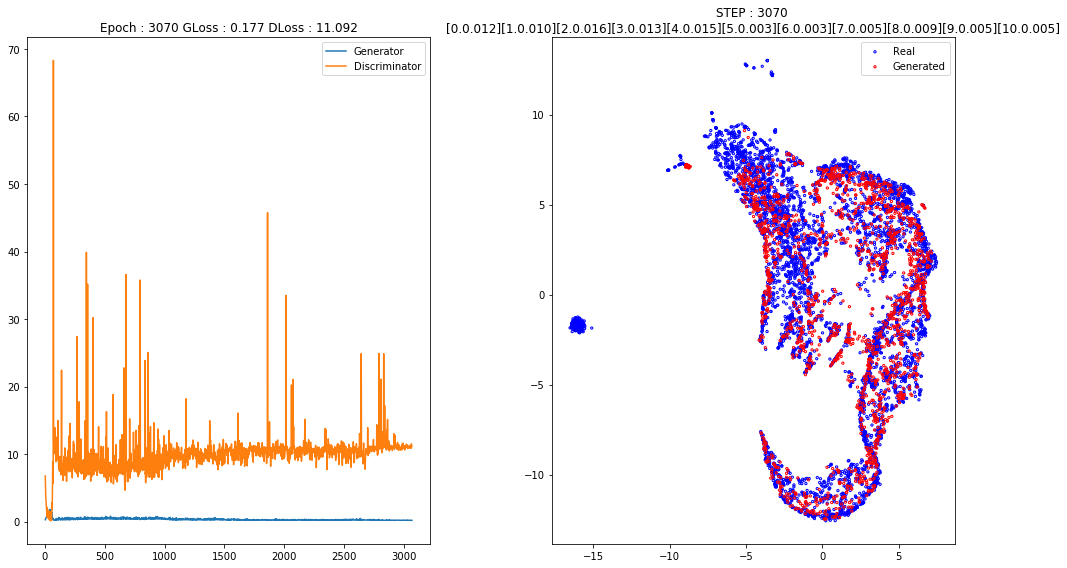

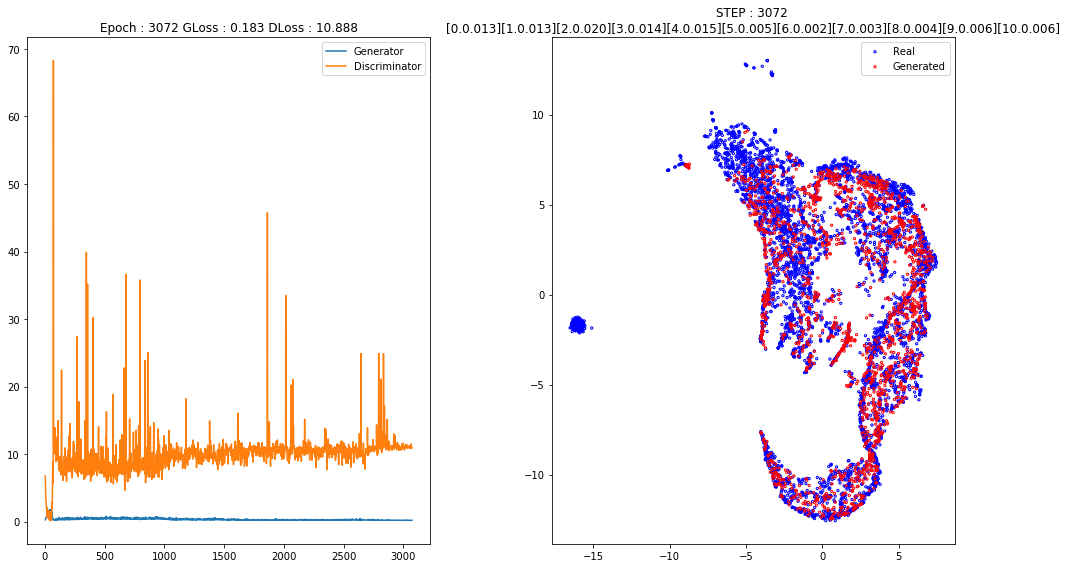

In [ ]:
steps = 10000
ng_steps , nd_steps = 1, 8
epochs = []
gen_loss_store = []
disc_loss_store = []
for epoch in range(steps):
    print(f'2a: {epoch:03d}/{steps}', end='\r')
    noise = generate_noise(BATCH_SIZE)
    target = data.sample(BATCH_SIZE).values
    n_gloss = 0
    feed_dict={
                global_step : epoch , 
                X : target ,
                Z : noise}
    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], 
                            feed_dict = feed_dict)
        n_gloss += gloss
    n_gloss /= ng_steps
    n_dloss = 0
    for _ in range(nd_steps):
        _, dloss  = sess.run([disc_step, disc_loss] , 
                             feed_dict = feed_dict)
        n_dloss += dloss
    
    n_gloss /= nd_steps
    if (epoch % 2 == 0) & (epoch > 0) :
        epochs.append(epoch)
        gen_loss_store.append(n_gloss)
        disc_loss_store.append(n_dloss)
        fig , axes = plt.subplots(nrows=1 ,ncols=2, figsize=(15,8) )
        ax = axes.flatten()
        plt.subplots_adjust(left=0.05, bottom=0.2, right=0.85, 
                            top=0.95, wspace=None, hspace=0.0)
        ax[0].plot( epochs , gen_loss_store , label = "Generator")
        ax[0].plot( epochs, disc_loss_store , label = "Discriminator")
        ax[0].set_title( "Epoch : {} GLoss : {:.3f} DLoss : {:.3f}".format(epoch ,n_gloss , n_dloss  ))
        ax[0].legend(loc=1)
        #plt.ylim(0,3)
        store = []
        generated_points = sess.run(G_sample , feed_dict = feed_dict)
        total_msg = "STEP : {} \n".format(epoch)
        for i in np.arange(target.shape[1]) :
            dist = np.round(wdist(generated_points[:,i] , target[:,i]),4)
            store.append(dist)
            msg = r"[{}.{:.3f}]".format(i,dist)
            total_msg = total_msg + msg
        generated_points = Umap.transform(generated_points)
    #     msg = "[1. {:.3f}][2. {:.3f}][3. {:.3f}][4. {:.3f}]".\
    #     format(store[0], store[1] , store[2], store[3])
        ax[1].scatter(output_points[:, 0], output_points[:, 1], 
                    edgecolor='blue', facecolor='None', s=5, alpha=1, 
                    linewidth=1, label='Real')
        ax[1].scatter(generated_points[:, 0], generated_points[:, 1], 
                    edgecolor='red', facecolor='None', s=5, alpha=1, 
                    linewidth=1, label='Generated')
        ax[1].set_title(total_msg , fontsize= 12)
        ax[1].legend(loc=1)
        plt.tight_layout()
        plt.savefig(f'ims/2/a/2a.{epoch:03d}.png')
        if epoch % 10 == 0 :
            clear_output()
        else :
            plt.show()
        

In [ ]:
import re
path = "ims/2/a"
paths = [os.path.join(path , i ) for i in os.listdir(path) if re.search(".png$", i )]
store1 = []
store2 = []
for i in paths :
    if len(i) == 19 :
        store2.append(i)
    else :
        store1.append(i)

paths = list(np.sort(store1)) + list(np.sort(store2))
#len('ims/2/a/2a.2710.png')

In [ ]:
pathIn= './ims/2/'
pathOut = './ims/2/gan.mp4'
fps = 30
import cv2
frame_array = []
for idx , path in enumerate(paths) : 
    if (idx % 2 == 0) | (idx % 5 == 0) :
        continue
    img = cv2.imread(path)
    height, width, layers = img.shape
    size = (width,height)
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

In [94]:
os.system(f'ffmpeg -r 30 -i ims/2/a/2a.*.png'
              f' -crf 30 ims/2/a/2a.mp4')

256

In [96]:
os.system('convert -delay 15 -loop 0 ims/2/a/2a.*.png ims/2/a/2a.gif')

2

In [124]:
import re
path = "ims/2/a"
paths = [os.path.join(path , i ) for i in os.listdir(path) if re.search(".png$", i )]

In [123]:
files.sort(key = lambda x: x[5:-4])

NameError: name 'files' is not defined

In [125]:
#paths

In [126]:
store1 = []
store2 = []
for i in paths :
    if len(i) == 19 :
        store2.append(i)
    else :
        store1.append(i)

paths = list(np.sort(store1)) + list(np.sort(store2))
#len('ims/2/a/2a.2710.png')

In [134]:
pathIn= './ims/2/'
pathOut = './ims/2/gan.mp4'
fps = 30
import cv2
frame_array = []
for idx , path in enumerate(paths) : 
    if (idx % 2 == 0) | (idx % 5 == 0) :
        continue
    img = cv2.imread(path)
    height, width, layers = img.shape
    size = (width,height)
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

In [66]:
'{0:04d}'.format(99999)

'99999'